In [154]:
from camel_tools.calima_star.database import CalimaStarDB
from camel_tools.calima_star.analyzer import CalimaStarAnalyzer
from camel_tools.disambig.mle import MLEDisambiguator
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.nn.utils.rnn import pad_sequence, pack_padded_sequence, pad_packed_sequence
from torch.utils.data import DataLoader, Dataset
import torch.nn.functional as F
import random
import csv
import json
import copy
import os
import argparse
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import re

In [155]:
class InputExample:
    """Simple object to encapsulate each data example"""
    def __init__(self, src, trg, 
                 src_g, trg_g):    
        self.src = src
        self.trg = trg
        self.src_g = src_g
        self.trg_g = trg_g
    
    def __repr__(self):
        return str(self.to_json_str())
    
    def to_json_str(self):
        return json.dumps(self.to_dict(), indent=2, ensure_ascii=False)
    
    def to_dict(self):
        output = copy.deepcopy(self.__dict__)
        return output

In [156]:
class RawDataset:
    """Encapsulates the raw examples in InputExample objects"""
    def __init__(self, data_dir):
        self.train_examples = self.get_train_examples(data_dir)
        self.dev_examples = self.get_dev_examples(data_dir)
        self.test_examples = self.get_dev_examples(data_dir)
        
    def create_examples(self, src_path, trg_path):
        
        src_txt = self.get_txt_examples(src_path)
        src_gender_labels = self.get_labels(src_path + '.label')
        trg_txt = self.get_txt_examples(trg_path)
        trg_gender_labels = self.get_labels(trg_path + '.label')
        
        examples = []
        
        for i in range(len(src_txt)):
            src = src_txt[i].strip()
            trg = trg_txt[i].strip()
            src_g = src_gender_labels[i].strip()
            trg_g = trg_gender_labels[i].strip()
            input_example = InputExample(src, trg, src_g, trg_g)
            examples.append(input_example)
        
        return examples
    
    def get_labels(self, data_dir):
        with open(data_dir) as f:
            return f.readlines()
        
    def get_txt_examples(self, data_dir):
        with open(data_dir, encoding='utf8') as f:
            return f.readlines()
    
    def get_train_examples(self, data_dir):
        """Reads the train examples of the dataset"""
        return self.create_examples(os.path.join(data_dir, 'D-set-train.arin'), 
                                    os.path.join(data_dir, 'D-set-train.ar.M'))
    
    def get_dev_examples(self, data_dir):
        """Reads the dev examples of the dataset"""
        return self.create_examples(os.path.join(data_dir, 'D-set-dev.arin'), 
                                    os.path.join(data_dir, 'D-set-dev.ar.M'))
    
    def get_test_examples(self, data_dir):
        """Reads the test examples of the dataset"""
        return self.create_examples(os.path.join(data_dir, 'D-set-test.arin'), 
                                    os.path.join(data_dir, 'D-set-test.ar.M'))

In [157]:
class Vocabulary:
    """Base vocabulary class"""
    def __init__(self, token_to_idx=None):
        
        if token_to_idx is None:
            token_to_idx = dict()
        
        self.token_to_idx = token_to_idx
        self.idx_to_token = {idx: token for token, idx in self.token_to_idx.items()}
    
    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index
    
    def add_many(self, tokens):
        return [self.add_token(token) for token in tokens]
    
    def lookup_token(self, token):
        return self.token_to_idx[token]
    
    def lookup_index(self, index):
        return self.idx_to_token[index]
    
    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx}
    
    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)
    
    def __len__(self):
        return len(self.token_to_idx)
    
class SeqVocabulary(Vocabulary):
    """Sequence vocabulary class"""
    def __init__(self, token_to_idx=None, unk_token='<unk>',
                 pad_token='<pad>', sos_token='<s>',
                 eos_token='</s>'):
        
        super(SeqVocabulary, self).__init__(token_to_idx)
        
        self.pad_token = pad_token
        self.unk_token = unk_token
        self.sos_token = sos_token
        self.eos_token = eos_token
        
        self.pad_idx = self.add_token(self.pad_token)
        self.unk_idx = self.add_token(self.unk_token)
        self.sos_idx = self.add_token(self.sos_token)
        self.eos_idx = self.add_token(self.eos_token)
        
    def to_serializable(self):
        contents = super(SeqVocabulary, self).to_serializable()
        contents.update({'unk_token': self.unk_token,
                         'pad_token': self.pad_token,
                         'sos_token': self.sos_token, 
                         'eos_token': self.eos_token})
        return contents
    
    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)
    
    def lookup_token(self, token):
        return self.token_to_idx.get(token, self.unk_idx)

In [158]:
class MorphFeaturizer:
    """Morphological Featurizer Class"""
    def __init__(self, analyzer_db_path):
        self.db = CalimaStarDB(analyzer_db_path)
        self.analyzer = CalimaStarAnalyzer(self.db, cache_size=46000)
        self.disambiguator = MLEDisambiguator(self.analyzer)
        self.w_to_features = {}
    
    def featurize(self, sentence):
        """
        Args:
            - sentence (str): a sentence in Arabic
        Returns:
            - a dictionary of word to vector mapping for each word in the sentence.
              Each vector will be a one-hot representing the following features:
              [lex+m lex+f spvar+m spvar+f]
        """
        # using the MLEDisambiguator to get the analyses
        disambiguations = self.disambiguator.disambiguate(sentence.split(' '), top=0)
        # disambiguations is a list of DisambiguatedWord objects
        # each DisambiguatedWord object is a tuple of: (word, scored_analyses)
        # scored_analyses is a list of ScoredAnalysis objects
        # each ScoredAnalysis object is a tuple of: (score, analysis)
    
        for disambig in disambiguations:
            word, scored_analyses = disambig
            if word not in self.w_to_features:
                self.w_to_features[word] = list()
                if scored_analyses:
                    for scored_analysis in scored_analyses:
                        # each analysis will have a vector
                        score, analysis = scored_analysis
                        features = np.zeros(4)

                        # getting the source and gender features
                        src = analysis['source']
                        gen = analysis['gen']

                        if src == 'lex' and gen == 'm':
                            features[0] = 1
                        elif src == 'lex' and gen == 'f':
                            features[1] = 1
                        elif src == 'spvar' and gen == 'm':
                            features[2] = 1
                        elif src == 'spvar' and gen == 'f':
                            features[3] = 1

                        self.w_to_features[word].append(features)

                    # squashing all the vectors into one
                    self.w_to_features[word] = np.array(self.w_to_features[word])
                    self.w_to_features[word] = self.w_to_features[word].sum(axis=0)
                    # replacing all the elements > 0 with 1
                    self.w_to_features[word][self.w_to_features[word] > 0] = 1
                    # replacing all the 0 elements with 1e-6
                    self.w_to_features[word][self.w_to_features[word] == 0] = 1e-6
                    self.w_to_features[word] = self.w_to_features[word].tolist()
                else:
                    self.w_to_features[word] = np.full((4), 1e-6).tolist()

    def featurize_sentences(self, sentences):
        """Featurizes a list of sentences"""
        for sentence in sentences:
            self.featurize(sentence)
    
    def to_serializable(self):
        return {'morph_features': self.w_to_features}
    
    def from_serializable(self, contents):
        self.w_to_features = contents['morph_features']
        
    def save_morph_features(self, path):
        with open(path, mode='w', encoding='utf8') as f:
            return json.dump(self.to_serializable(), f, ensure_ascii=False)
    
    def load_morph_features(self, path):
        with open(path) as f:
            return self.from_serializable(json.load(f))

In [159]:
class Vectorizer:
    """Vectorizer Class"""
    def __init__(self, src_vocab_char, trg_vocab_char, src_vocab_word, trg_vocab_word):
        """src_vocab_char and trg_vocab_char 
        are on the char level. src_vocab_word and 
        trg_vocab_word are on the word level"""
        self.src_vocab_char = src_vocab_char
        self.trg_vocab_char = trg_vocab_char
        self.src_vocab_word = src_vocab_word
        self.trg_vocab_word = trg_vocab_word
        
    @classmethod
    def create_vectorizer(cls, data_examples):
        """Class method which builds the vectorizer
        vocab"""
        
        src_vocab_char = SeqVocabulary()
        trg_vocab_char = SeqVocabulary()
        src_vocab_word = SeqVocabulary()
        trg_vocab_word = SeqVocabulary()
        
        for ex in data_examples:
            src = ex.src
            trg = ex.trg
            
            # splitting by a regex to maintain the space
            src = re.split(r'(\s+)', src)
            trg = re.split(r'(\s+)', trg)
    
            for word in src:
                src_vocab_word.add_token(word)
                src_vocab_char.add_many(list(word))
                
            for word in trg:
                trg_vocab_word.add_token(word)
                trg_vocab_char.add_many(list(word))
        
        return cls(src_vocab_char, trg_vocab_char, src_vocab_word, trg_vocab_word)
    
    def get_src_indices(self, seq):
        """
        Args:
          - seq (str): The src sequence
        
        Returns:
          - char_level_indices (list): <s> + List of chars to index mapping + </s>
          - word_level_indices (list): <s> + List of words to index mapping + </s>
        """
        char_level_indices = [self.src_vocab_char.sos_idx]
        word_level_indices = [self.src_vocab_word.sos_idx]
        seq = re.split(r'(\s+)', seq)
        for word in seq:
            for c in word:
                char_level_indices.append(self.src_vocab_char.lookup_token(c))
                word_level_indices.append(self.src_vocab_word.lookup_token(word))
        
        word_level_indices.append(self.src_vocab_word.eos_idx)
        char_level_indices.append(self.src_vocab_char.eos_idx)
        
        assert len(word_level_indices) == len(char_level_indices)
        return char_level_indices, word_level_indices
    
    def get_trg_indices(self, seq):
        """
        Args:
          - seq (str): The trg sequence
        
        Returns:
          - trg_x_indices (list): <s> + List of chars to index mapping
          - trg_y_indices (list): List of chars to index mapping + </s>
        """
        indices = [self.trg_vocab_char.lookup_token(t) for t in seq]
        
        trg_x_indices = [self.trg_vocab_char.sos_idx] + indices
        trg_y_indices = indices + [self.trg_vocab_char.eos_idx]
        return trg_x_indices, trg_y_indices
    
    
    def vectorize(self, src, trg):
        """
        Args:
          - src (str): The src sequence
          - src (str): The trg sequence
        Returns:
          - vectorized_src_char
          - vectorized_src_word
          - vectorized_trg_x 
          - vectorized_trg_y
        """
        src = src
        trg = trg
        
        vectorized_src_char, vectorized_src_word = self.get_src_indices(src)
        vectorized_trg_x, vectorized_trg_y = self.get_trg_indices(trg)
        
        return {'src_char': torch.tensor(vectorized_src_char, dtype=torch.long),
                'src_word': torch.tensor(vectorized_src_word, dtype=torch.long),
                'trg_x': torch.tensor(vectorized_trg_x, dtype=torch.long),
                'trg_y': torch.tensor(vectorized_trg_y, dtype=torch.long)
               }
    
    def to_serializable(self):
        return {'src_vocab_char': self.src_vocab_char.to_serializable(),
                'trg_vocab_char': self.trg_vocab_char.to_serializable(),
                'src_vocab_word': self.src_vocab_word.to_serializable(),
                'trg_vocab_word': self.trg_vocab_word.to_serializable()
               }
    
    @classmethod
    def from_serializable(cls, contents):
        src_vocab_char = SeqVocabulary.from_serializable(contents['src_vocab_char'])
        trg_vocab_char = SeqVocabulary.from_serializable(contents['trg_vocab_char'])
        src_vocab_word = SeqVocabulary.from_serializable(contents['src_vocab_word'])
        trg_vocab_word = SeqVocabulary.from_serializable(contents['trg_vocab_word'])
        return cls(src_vocab_char, trg_vocab_char, src_vocab_word, trg_vocab_word)

In [160]:
class MT_Dataset(Dataset):
    """MT Dataset as a PyTorch dataset"""
    def __init__(self, raw_dataset, vectorizer):
        self.vectorizer = vectorizer
        self.train_examples = raw_dataset.train_examples
        self.dev_examples = raw_dataset.dev_examples
        self.test_examples = raw_dataset.test_examples
        self.lookup_split = {'train': self.train_examples,
                             'dev': self.dev_examples,
                             'test': self.test_examples}
        self.set_split('train')
    
    def get_vectorizer(self):
        return self.vectorizer
    
    @classmethod
    def load_data_and_create_vectorizer(cls, data_dir):
        raw_dataset = RawDataset(data_dir)
        # Note: we always create the vectorizer based on the train examples
        vectorizer = Vectorizer.create_vectorizer(raw_dataset.train_examples)
        return cls(raw_dataset, vectorizer)
    
    @classmethod
    def load_data_and_load_vectorizer(cls, data_dir, vec_path):
        raw_dataset = RawDataset(data_dir)
        vectorizer = cls.load_vectorizer(vec_path)
        return cls(raw_dataset, vectorizer)
    
    @staticmethod
    def load_vectorizer(vec_path):
        with open(vec_path) as f:
            return Vectorizer.from_serializable(json.load(f))
    
    def save_vectorizer(self, vec_path):
        with open(vec_path, 'w') as f:
            return json.dump(self.vectorizer.to_serializable(), f)
        
    def set_split(self, split):
        self.split = split
        self.split_examples = self.lookup_split[self.split]
        return self.split_examples
    
    def __getitem__(self, index):
        example = self.split_examples[index]
        src, trg = example.src, example.trg
        vectorized = self.vectorizer.vectorize(src, trg)
        return vectorized
    
    def __len__(self):
        return len(self.split_examples)
    
    
class Collator:
    def __init__(self, src_pad_idx, trg_pad_idx):
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        
    def __call__(self, batch):
        # Sorting the batch by src seqs length in descending order
        sorted_batch = sorted(batch, key=lambda x: x['src_char'].shape[0], reverse=True)
        
        src_char_seqs = [x['src_char'] for x in sorted_batch]
        src_word_seqs = [x['src_word'] for x in sorted_batch]
        assert len(src_word_seqs) == len(src_char_seqs)
        trg_x_seqs = [x['trg_x'] for x in sorted_batch]
        trg_y_seqs = [x['trg_y'] for x in sorted_batch]
        lengths = [len(seq) for seq in src_char_seqs]
        
        padded_src_char_seqs = pad_sequence(src_char_seqs, batch_first=True, padding_value=self.src_pad_idx)
        padded_src_word_seqs = pad_sequence(src_word_seqs, batch_first=True, padding_value=self.src_pad_idx)
        padded_trg_x_seqs = pad_sequence(trg_x_seqs, batch_first=True, padding_value=self.trg_pad_idx)
        padded_trg_y_seqs = pad_sequence(trg_y_seqs, batch_first=True, padding_value=self.trg_pad_idx)
        lengths = torch.tensor(lengths, dtype=torch.long)
        
        return {'src_char': padded_src_char_seqs,
                'src_word': padded_src_word_seqs,
                'trg_x': padded_trg_x_seqs,
                'trg_y': padded_trg_y_seqs,
                'src_lengths': lengths}

In [161]:
def make_morph_embeddings(morph_featurizer, word_vocab):
    """Creating a morphological features embedding matrix"""
    morph_features = morph_featurizer.w_to_features
    
    # Note: morph_features will have all the words in word_vocab
    # except: <s>, pad, unk, </s>, ' '
    
    # Creating a zero embedding matrix of shape: (len(word_vocab), 4)
    morph_embedding_matrix = torch.ones((len(word_vocab), 4)) * 1e-6
    for word in word_vocab.token_to_idx:
        if word in morph_features:
            index = word_vocab.lookup_token(word)
            morph_embedding_matrix[index] = torch.tensor(morph_features[word], dtype=torch.float64)
    return morph_embedding_matrix

In [162]:
class Encoder(nn.Module):
    """Encoder bi-GRU"""
    def __init__(self, input_dim, embed_dim,
                 hidd_dim, morph_embedding,
                 char_padding_idx=0, word_padding_idx=0):
        
        super(Encoder, self).__init__()
        self.char_embedding_layer = nn.Embedding(input_dim, embed_dim, padding_idx=char_padding_idx)
        self.morph_embedding_layer = nn.Embedding.from_pretrained(morph_embedding,
                                                                  padding_idx=word_padding_idx)
        self.rnn = nn.GRU(embed_dim + 4, hidd_dim, batch_first=True, bidirectional=True)
        
    def forward(self, char_src_seqs, word_src_seqs, src_seqs_lengths):
    
        embedded_char_seqs = self.char_embedding_layer(char_src_seqs)
        # embedded_char_seqs shape: [batch_size, max_src_seq_len, embed_dim]
        
        embedded_word_seqs = self.morph_embedding_layer(word_src_seqs)
        # embedded_char_seqs shape: [batch_size, max_src_seq_len, 4]

        embedded_seqs = torch.cat((embedded_char_seqs, embedded_word_seqs), dim=2)
        # embedded_seqs shape: [batch_size, max_src_seq_len, embed_dim + 4]
        
        # packing the embedded_seqs
        packed_embedded_seqs = pack_padded_sequence(embedded_seqs, src_seqs_lengths, batch_first=True)
        
        output, hidd = self.rnn(packed_embedded_seqs)
        # hidd shape: [num_layers * num_dirs, batch_size, hidd_dim]
        
        # changing hidd shape to: [batch_size, num_layers * num_dirs, hidd_dim]
        hidd = hidd.permute(1, 0 ,2)
        
        # changing hidd shape to: [batch_size, num_layers * num_dirs * hidd_dim]
        hidd = hidd.contiguous().view(hidd.shape[0], -1)
        
        # unpacking the output
        output, lengths = pad_packed_sequence(output, batch_first=True)
        # output shape: [batch_size, src_seqs_length, num_dirs * hidd_dim]
        return output, hidd

In [163]:
class Decoder(nn.Module):
    """Decoder GRU
       
       Things to note:
           - The input to the decoder rnn at each time step is the 
             concatenation of the embedded token and the context vector
           - The context vector will have a size of batch_size, hidd_dim
           - Note that the decoder hidd_dim == the encoder hidd_dim * 2
           - The prediction layer input is the concatenation of 
             the context vector and the h_t of the decoder
    """
    def __init__(self, input_dim, embed_dim,
                 hidd_dim, output_dim,
                 attention,
                 padding_idx=0):
        
        super(Decoder, self).__init__()
        self.hidd_dim = hidd_dim
        self.attention = attention
        self.embedding_layer = nn.Embedding(input_dim, embed_dim, padding_idx=padding_idx)
        # the input to the rnn is the context_vector + embedded token --> embed_dim + hidd_dim
        self.rnn = nn.GRUCell((embed_dim + hidd_dim), hidd_dim)
        # the input to the classifier is h_t + context_vector --> hidd_dim * 2
        self.classification_layer = nn.Linear(hidd_dim * 2, output_dim)
        
    
    def forward(self, trg_seqs, encoder_outputs, decoder_h_t, context_vectors, attention_mask):
        # trg_seqs shape: [batch_size]
        batch_size = trg_seqs.shape[0]

        # Step 1: embedding the target seqs
        embedded_seqs = self.embedding_layer(trg_seqs)
        # embedded_seqs shape: [batch_size, embed_dim]
        
        # concatenating the embedded trg sequence with the context_vectors
        rnn_input = torch.cat((embedded_seqs, context_vectors), dim=1)
        # rnn_input shape: [batch_size, embed_dim + hidd_dim]
        
        # Step 2: feeding the input to the rnn and updating the decoder_h_t
        decoder_h_t = self.rnn(rnn_input, decoder_h_t)
        # decoder_h_t shape: [batch_size, hidd_dim]
        
        # Step 3: updating the context vectors through attention
        context_vectors, atten_scores = self.attention(key_vectors=encoder_outputs, 
                                                       query_vector=decoder_h_t,
                                                       mask=attention_mask)
        
        # concatenating decoder_h_t with the context_vectors to create a 
        # prediction vector
        predictions_vector = torch.cat((decoder_h_t, context_vectors), dim=1)
        # predictions_vector: [batch_size, hidd_dim * 2]
        
        # Step 4: feeding the prediction vector to the fc layer
        # to a make a prediction
        prediction = self.classification_layer(predictions_vector)
        # prediction shape: [batch_size, output_dim]
        
        return prediction, decoder_h_t, atten_scores, context_vectors

In [164]:
class AdditiveAttention(nn.Module):
    """Attention mechanism as a MLP 
    as used by Bahdanau et. al 2015"""

    def __init__(self, encoder_hidd_dim, decoder_hidd_dim):
        super(AdditiveAttention, self).__init__()
        self.atten = nn.Linear((encoder_hidd_dim * 2) + decoder_hidd_dim, decoder_hidd_dim)
        self.v = nn.Linear(decoder_hidd_dim, 1)
        
    def forward(self, key_vectors, query_vector, mask):
        """key_vectors: encoder hidden states.
           query_vector: decoder hidden state at time t
           mask: the mask vector of zeros and ones
        """
        
        #key_vectors shape: [batch_size, src_seq_length, encoder_hidd_dim * 2]
        #query_vector shape: [batch_size, decoder_hidd_dim]
        #Note: encoder_hidd_dim * 2 == decoder_hidd_dim
        
        batch_size, src_seq_length, encoder_hidd_dim = key_vectors.shape
        
        #changing the shape of query_vector to [batch_size, src_seq_length, decoder_hidd_dim]
        #we will repeat the query_vector src_seq_length times at dim 1
        query_vector = query_vector.unsqueeze(1).repeat(1, src_seq_length, 1)
        
        # Step 1: Compute the attention scores through a MLP
        
        # concatenating the key_vectors and the query_vector
        atten_input = torch.cat((key_vectors, query_vector), dim=2)
        # atten_input shape: [batch_size, src_seq_length, (encoder_hidd_dim * 2) + decoder_hidd_dim]
        
        atten_scores = self.atten(atten_input)
        # atten_scores shape: [batch_size, src_seq_length, decoder_hidd_dim]

        atten_scores = torch.tanh(atten_scores)
    
        # mapping atten_scores from decoder_hidd_dim to 1
        atten_scores = self.v(atten_scores)
    
        # atten_scores shape: [batch_size, src_seq_length, 1]
        atten_scores = atten_scores.squeeze(dim=2)
        # atten_scores shape: [batch_size, src_seq_length]
        
        # masking the atten_scores
        atten_scores = atten_scores.masked_fill(mask == 0, -1e10)
        
        # Step 2: normalizing atten_scores through a softmax to get probs
        atten_scores = F.softmax(atten_scores, dim=1)
        
        # Step 3: computing the new context vector
        context_vectors = torch.matmul(key_vectors.permute(0, 2, 1), atten_scores.unsqueeze(2)).squeeze(dim=2)
        
        # context_vectors shape: [batch_size, encoder_hidd_dim * 2]
        
        return context_vectors, atten_scores
        

In [165]:
class Seq2Seq(nn.Module):
    """Seq2Seq model"""
    def __init__(self, encoder_input_dim, encoder_embed_dim,
                 encoder_hidd_dim, decoder_input_dim, 
                 decoder_embed_dim, decoder_output_dim,
                 morph_embedding_matrix=None, src_char_padding_idx=0, 
                 src_word_padding_idx=0, trg_padding_idx=0,
                 trg_sos_idx=2):
        
        super(Seq2Seq, self).__init__()

        self.encoder = Encoder(input_dim=encoder_input_dim,
                               embed_dim=encoder_embed_dim,
                               hidd_dim=encoder_hidd_dim,
                               morph_embedding=morph_embedding_matrix,
                               char_padding_idx=src_char_padding_idx,
                               word_padding_idx=src_word_padding_idx)
        
        self.decoder_hidd_dim = encoder_hidd_dim * 2
        
        self.attention = AdditiveAttention(encoder_hidd_dim=encoder_hidd_dim,
                                           decoder_hidd_dim=self.decoder_hidd_dim)
        
        self.decoder = Decoder(input_dim=decoder_input_dim,
                               embed_dim=decoder_embed_dim,
                               hidd_dim=self.decoder_hidd_dim,
                               output_dim=decoder_input_dim,
                               attention=self.attention,
                               padding_idx=trg_padding_idx)
        
        self.src_padding_idx = src_char_padding_idx
        self.trg_sos_idx = trg_sos_idx
        self.sampling_temperature = 3
        
    def create_mask(self, src_seqs, src_padding_idx):
        mask = (src_seqs != src_padding_idx)
        return mask
    
    def forward(self, char_src_seqs, word_src_seqs, src_seqs_lengths, trg_seqs, teacher_forcing_prob=0.3):
        # trg_seqs shape: [batch_size, trg_seqs_length]
        # reshaping to: [trg_seqs_length, batch_size]
        trg_seqs = trg_seqs.permute(1, 0)
        trg_seqs_length, batch_size = trg_seqs.shape
        
        # passing the src to the encoder
        encoder_outputs, encoder_hidd = self.encoder(char_src_seqs, word_src_seqs, src_seqs_lengths)
        
        # creating attention masks
        attention_mask = self.create_mask(char_src_seqs, self.src_padding_idx)

        predictions = []
        decoder_attention_scores = []
        
        # initializing the trg_seqs to <s> token
        y_t = torch.ones(batch_size, dtype=torch.long) * self.trg_sos_idx
        
        # intializing the context_vectors to zero
        context_vectors = torch.zeros(batch_size, self.decoder_hidd_dim)
        
        # initializing the hidden state of the decoder to the encoder hidden state
        decoder_h_t = encoder_hidd
        
        # moving y_t and context_vectors to the right device
        y_t = y_t.to(encoder_hidd.device)
        context_vectors = context_vectors.to(encoder_hidd.device)
        
        for i in range(trg_seqs_length):
            teacher_forcing = np.random.random() < teacher_forcing_prob
            # if teacher_forcing, use ground truth target tokens
            # as an input to the decoder
            if teacher_forcing:
                y_t = trg_seqs[i]
            
            # do a single decoder step
            prediction, decoder_h_t, atten_scores, context_vectors = self.decoder(y_t, 
                                                                                  encoder_outputs, 
                                                                                  decoder_h_t, 
                                                                                  context_vectors, 
                                                                                  attention_mask=attention_mask)
            
#             # updating the context_vectors 
#             context_vectors, atten_scores = self.attention(key_vectors=encoder_outputs, query_vector=decoder_h_t,
#                                                            mask=attention_mask)
            # If not teacher force, use the maximum 
            # prediction as an input to the decoder in 
            # the next time step
            if not teacher_forcing:
                # we multiply the predictions with a sampling_temperature
                # to make the propablities peakier, so we can be confident about the
                # maximum prediction
                pred_output_probs = F.softmax(prediction * self.sampling_temperature, dim=1)
                y_t = torch.argmax(pred_output_probs, dim=1)

            predictions.append(prediction)
            decoder_attention_scores.append(atten_scores)
        
        
        predictions = torch.stack(predictions)
        # predictions shape: [trg_seq_len, batch_size, output_dim]
        predictions = predictions.permute(1, 0, 2)
        # predictions shape: [batch_size, trg_seq_len, output_dim]
    
    
        decoder_attention_scores = torch.stack(decoder_attention_scores)
        # attention_scores_total shape: [trg_seq_len, batch_size, src_seq_len]
        decoder_attention_scores = decoder_attention_scores.permute(1, 0, 2)
        # attention_scores_total shape: [batch_size, trg_seq_len, src_seq_len]
        
        return predictions, decoder_attention_scores

In [166]:
def set_seed(seed, cuda):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed(seed)

In [167]:
args = argparse.Namespace(data_dir='/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus',
                          vectorizer_path='/home/ba63/gender-bias/models/saved_models/char_level_vectorizer.json',
                          morph_features_path='/home/ba63/databases/morph_features.json',
                          analyzer_db_path='/home/ba63/databases/calima-msa/calima-msa.0.2.2.utf8.db',
                          use_morph_embeddings=True,
                          reload_files=False,
                          cache_files=True,
                          num_epochs=50,
                          embedding_dim=32,
                          hidd_dim=64,
                          learning_rate=5e-4,
                          use_cuda=True,
                          batch_size=64,
                          seed=21,
                          model_path='/home/ba63/gender-bias/models/saved_models/char_level_model_small_morph_1e-10.pt'
                          )

device = torch.device('cuda' if args.use_cuda else 'cpu')
set_seed(args.seed, args.use_cuda)

In [168]:
morph_featurizer = MorphFeaturizer(args.analyzer_db_path)
if args.reload_files:
    dataset = MT_Dataset.load_data_and_load_vectorizer(args.data_dir, args.vectorizer_path)
    morph_featurizer.load_morph_features(args.morph_features_path)
else:
    dataset = MT_Dataset.load_data_and_create_vectorizer(args.data_dir)
    # TODO: Find a better way to integrate the morph analyzer
    src_train_sentences = [t.src for t in dataset.train_examples]
    morph_featurizer.featurize_sentences(src_train_sentences)

if args.cache_files:
    dataset.save_vectorizer(args.vectorizer_path)
    morph_featurizer.save_morph_features(args.morph_features_path)

vectorizer = dataset.get_vectorizer()

if args.use_morph_embeddings:
    morph_embeddings_matrix = make_morph_embeddings(morph_featurizer, vectorizer.src_vocab_word)
    
ENCODER_INPUT_DIM = len(vectorizer.src_vocab_char)
DECODER_INPUT_DIM = len(vectorizer.trg_vocab_char)
DECODER_OUTPUT_DIM = len(vectorizer.trg_vocab_char)
SRC_CHAR_PAD_INDEX = vectorizer.src_vocab_char.pad_idx
SRC_WORD_PAD_INDEX = vectorizer.src_vocab_word.pad_idx
TRG_PAD_INDEX = vectorizer.trg_vocab_char.pad_idx
TRG_SOS_INDEX = vectorizer.trg_vocab_char.sos_idx

In [174]:
model = Seq2Seq(encoder_input_dim=ENCODER_INPUT_DIM,
                encoder_embed_dim=args.embedding_dim,
                encoder_hidd_dim=args.hidd_dim,
                decoder_input_dim=DECODER_INPUT_DIM,
                decoder_embed_dim=args.embedding_dim,
                decoder_output_dim=DECODER_OUTPUT_DIM,
                morph_embedding_matrix=morph_embeddings_matrix,
                src_char_padding_idx=SRC_CHAR_PAD_INDEX,
                src_word_padding_idx=SRC_WORD_PAD_INDEX,
                trg_padding_idx=TRG_PAD_INDEX,
                trg_sos_idx=TRG_SOS_INDEX)
                    
optimizer = optim.Adam(model.parameters(), lr=args.learning_rate)
criterion = nn.CrossEntropyLoss(ignore_index=TRG_PAD_INDEX)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min',
                                                 patience=2, factor=0.5)
model

Seq2Seq(
  (encoder): Encoder(
    (char_embedding_layer): Embedding(71, 32, padding_idx=0)
    (morph_embedding_layer): Embedding(13894, 4, padding_idx=0)
    (rnn): GRU(36, 64, batch_first=True, bidirectional=True)
  )
  (attention): AdditiveAttention(
    (atten): Linear(in_features=256, out_features=128, bias=True)
    (v): Linear(in_features=128, out_features=1, bias=True)
  )
  (decoder): Decoder(
    (attention): AdditiveAttention(
      (atten): Linear(in_features=256, out_features=128, bias=True)
      (v): Linear(in_features=128, out_features=1, bias=True)
    )
    (embedding_layer): Embedding(71, 32, padding_idx=0)
    (rnn): GRUCell(160, 128)
    (classification_layer): Linear(in_features=256, out_features=71, bias=True)
  )
)

In [175]:
def train(model, dataloader, optimizer, criterion, device='cpu', teacher_forcing_prob=0.3):
    model.train()
    epoch_loss = 0
    for batch in dataloader:
        optimizer.zero_grad()
        batch = {k: v.to(device) for k, v in batch.items()}
        src_char = batch['src_char']
        src_word = batch['src_word']
        trg_x = batch['trg_x']
        trg_y = batch['trg_y']
        src_lengths = batch['src_lengths']
        
        
        preds, attention_scores = model(src_char, src_word, src_lengths, trg_x,
                                        teacher_forcing_prob=teacher_forcing_prob)
        
        # CrossEntropyLoss accepts matrices always! 
        # the preds must be of size (N, C) where C is the number 
        # of classes and N is the number of samples. 
        # The ground truth must be a Vector of size C!
        preds = preds.contiguous().view(-1, preds.shape[-1])
        trg_y = trg_y.view(-1)

        loss = criterion(preds, trg_y)
        epoch_loss += loss.item()
        
        loss.backward()
        optimizer.step()
        
    return epoch_loss / len(dataloader)


def evaluate(model, dataloader, criterion, device='cpu', teacher_forcing_prob=0):
    model.eval()
    epoch_loss = 0
    with torch.no_grad():
        for batch in dataloader:
            batch = {k: v.to(device) for k, v in batch.items()}
            src_char = batch['src_char']
            src_word = batch['src_word']
            trg_x = batch['trg_x']
            trg_y = batch['trg_y']
            src_lengths = batch['src_lengths']
            
            # we turn off teacher_forcing during evaluation
            preds, attention_scores = model(src_char, src_word, src_lengths, trg_x, 
                                            teacher_forcing_prob=teacher_forcing_prob)
            # CrossEntropyLoss accepts matrices always! 
            # the preds must be of size (N, C) where C is the number 
            # of classes and N is the number of samples. 
            # The ground truth must be a Vector of size C!
            preds = preds.contiguous().view(-1, preds.shape[-1])
            trg_y = trg_y.view(-1)
            
            loss = criterion(preds, trg_y)
            epoch_loss += loss.item()
            
    return epoch_loss / len(dataloader)

In [176]:
model = model.to(device)
collator = Collator(SRC_CHAR_PAD_INDEX, TRG_PAD_INDEX)
best_loss = 1e10
set_seed(args.seed, args.use_cuda)
train_losses = []
dev_losses = []
print(f'Using {device}')
for epoch in range(args.num_epochs):
#     teacher_forcing_prob = (epoch + 5) / args.num_epochs
    teacher_forcing_prob = 0.3
    dataset.set_split('train')
    dataloader = DataLoader(dataset, shuffle=True, batch_size=args.batch_size, collate_fn=collator, drop_last=True)
    train_loss = train(model, dataloader, optimizer, criterion, device, teacher_forcing_prob=teacher_forcing_prob)
    train_losses.append(train_loss)
    
    dataset.set_split('dev')
    dataloader = DataLoader(dataset, shuffle=True, batch_size=args.batch_size, collate_fn=collator, drop_last=True)
    dev_loss = evaluate(model, dataloader, criterion, device, teacher_forcing_prob=0)
    dev_losses.append(dev_loss)
    
    #save best model
    if dev_loss < best_loss:
        best_loss = dev_loss
        torch.save(model.state_dict(), args.model_path)
    
    # calling the scheduler
    scheduler.step(dev_loss)

    print(f'Epoch: {(epoch + 1)}')
    print(f'\tTrain Loss: {train_loss:.4f}   |   Dev Loss: {dev_loss:.4f}')

Using cuda
Epoch: 1
	Train Loss: 3.2312   |   Dev Loss: 3.0746
Epoch: 2
	Train Loss: 2.9252   |   Dev Loss: 2.8195
Epoch: 3
	Train Loss: 2.4998   |   Dev Loss: 2.3328
Epoch: 4
	Train Loss: 1.9682   |   Dev Loss: 2.0000
Epoch: 5
	Train Loss: 1.5458   |   Dev Loss: 1.6660
Epoch: 6
	Train Loss: 1.2882   |   Dev Loss: 1.4443
Epoch: 7
	Train Loss: 1.0250   |   Dev Loss: 1.0527
Epoch: 8
	Train Loss: 0.8651   |   Dev Loss: 0.9396
Epoch: 9
	Train Loss: 0.7352   |   Dev Loss: 0.8209
Epoch: 10
	Train Loss: 0.6508   |   Dev Loss: 0.8397
Epoch: 11
	Train Loss: 0.5419   |   Dev Loss: 1.1992
Epoch: 12
	Train Loss: 0.5658   |   Dev Loss: 1.4264
Epoch: 13
	Train Loss: 0.4104   |   Dev Loss: 0.8325
Epoch: 14
	Train Loss: 0.3749   |   Dev Loss: 0.5127
Epoch: 15
	Train Loss: 0.3574   |   Dev Loss: 0.6118
Epoch: 16
	Train Loss: 0.3405   |   Dev Loss: 0.4653
Epoch: 17
	Train Loss: 0.3449   |   Dev Loss: 0.4721
Epoch: 18
	Train Loss: 0.3394   |   Dev Loss: 0.4406
Epoch: 19
	Train Loss: 0.3037   |   Dev Loss

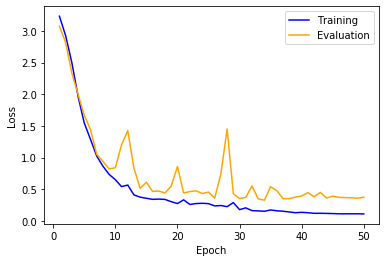

In [177]:
plt.plot(range(1, 1 + args.num_epochs), np.asarray(train_losses), 'b-', color='blue', label='Training')
plt.plot(range(1, 1 + args.num_epochs), np.asarray(dev_losses), 'b-', color='orange', label='Evaluation')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()


In [178]:
class NMT_Batch_Sampler:
    def __init__(self, model, src_vocab_char, src_vocab_word, trg_vocab):
        self.model = model
        self.src_vocab_char = src_vocab_char
        self.src_vocab_word = src_vocab_word
        self.trg_vocab = trg_vocab
    
    def update_batch(self, batch):
        self.sample_batch = batch
        
        src_char = batch['src_char']
        src_word = batch['src_word']
        trg_x = batch['trg_x']
        trg_y = batch['trg_y']
        src_lengths = batch['src_lengths']

        preds, attention_scores = self.model(src_char, src_word, src_lengths, trg_x, teacher_forcing_prob=0)
        # preds shape: [batch_size, trg_seq_len, output_dim]
        
        self.sample_batch['preds'] = preds
        self.sample_batch['attention_scores'] = attention_scores
        return self.sample_batch
    
    def get_pred_sentence(self, index):
        preds = self.sample_batch['preds']
       
        max_preds = torch.argmax(preds, dim=2)
        # max_preds shape: [batch_size, trg_seq_len]
        max_pred_sentence = max_preds[index].cpu().detach().numpy()
        return self.get_str_sentence(max_pred_sentence, self.trg_vocab)
    
    def get_trg_sentence(self, index):
        trg_sentence = self.sample_batch['trg_y'][index].cpu().detach().numpy()
        return self.get_str_sentence(trg_sentence, self.trg_vocab)
    
    def get_src_sentence(self, index):
        src_sentence = self.sample_batch['src_char'][index].cpu().detach().numpy()
        return self.get_str_sentence(src_sentence, self.src_vocab_char)
    
    def get_str_sentence(self, vectorized_sentence, vocab):
        sentence = []
        for i in vectorized_sentence:
            if i == vocab.sos_idx:
                continue
            elif i == vocab.eos_idx:
                break
            else:
                sentence.append(vocab.lookup_index(i))
        return ''.join(sentence)
    
    def translate_sentence(self, sentence, max_len=120):

        # vectorizing the src sentence on the char level and word level
        sentence = re.split(r'(\s+)', sentence)
        vectorized_src_sentence_char = [self.src_vocab_char.sos_idx]
        vectorized_src_sentence_word = [self.src_vocab_word.sos_idx]
        for word in sentence:
            for c in word:
                vectorized_src_sentence_char.append(self.src_vocab_char.lookup_token(c))
                vectorized_src_sentence_word.append(self.src_vocab_word.lookup_token(word))
        
        vectorized_src_sentence_word.append(self.src_vocab_word.eos_idx)
        vectorized_src_sentence_char.append(self.src_vocab_char.eos_idx)
        
        # getting sentence length
        src_sentence_length = [len(vectorized_src_sentence_char)]
        
        # converting the lists to tensors
        vectorized_src_sentence_char = torch.tensor([vectorized_src_sentence_char], dtype=torch.long)
        vectorized_src_sentence_word = torch.tensor([vectorized_src_sentence_word], dtype=torch.long)
        src_sentence_length = torch.tensor(src_sentence_length, dtype=torch.long)
        
        # passing the src sentence to the encoder
        with torch.no_grad():
            encoder_outputs, encoder_h_t= self.model.encoder(vectorized_src_sentence_char,
                                                             vectorized_src_sentence_word,
                                                             src_sentence_length)
        
        # creating attention mask
        attention_mask = self.model.create_mask(vectorized_src_sentence_char, self.src_vocab_char.pad_idx)
        
        # initilizating the first decoder_h_t to encoder_h_t
        decoder_h_t = encoder_h_t
        
        # initializing the context vectors to 0
        context_vectors = torch.zeros(1, self.model.decoder.hidd_dim)
        
        # intializing the trg sequences to the <s> token
        trg_seqs = [self.trg_vocab.sos_idx]
        
        with torch.no_grad():
            for i in range(max_len):
                y_t = torch.tensor([trg_seqs[-1]], dtype=torch.long)

                # do a single decoder step
                prediction, decoder_h_t, atten_scores, context_vectors = self.model.decoder(y_t, 
                                                                                          encoder_outputs, 
                                                                                          decoder_h_t, 
                                                                                          context_vectors, 
                                                                                          attention_mask=attention_mask)

                # getting the most probable prediciton
                max_pred = torch.argmax(prediction, dim=1).item()

                # if we reach </s> token, stop decoding
                if max_pred == self.trg_vocab.eos_idx:
                    break

                trg_seqs.append(max_pred)

        str_sentence = self.get_str_sentence(trg_seqs, self.trg_vocab)
        return str_sentence

In [179]:
set_seed(args.seed, args.use_cuda)
dataset.set_split('train')
model.load_state_dict(torch.load(args.model_path))
device = torch.device('cpu')
model = model.to(device)
model.eval()
collator = Collator(SRC_CHAR_PAD_INDEX, TRG_PAD_INDEX)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collator)
sampler = NMT_Batch_Sampler(model, vectorizer.src_vocab_char, vectorizer.src_vocab_word, vectorizer.trg_vocab_char)

In [180]:
train_preds = open(
    '/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus/'\
    'edits_annotations/char_level_model_small_morph_new.train_preds', 'w')

In [181]:
train_preds_inf = open(
    '/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus/'\
    'edits_annotations/char_level_model_small_morph_new.train_preds.inf', 'w')

In [182]:
train_log = open(
    '/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus/'\
    'edits_annotations/char_level_model_small_morph_new.train_log.inf', 'w')

In [183]:
for batch in dataloader:
    updated_batch = sampler.update_batch(batch)

#     print(updated_batch['trg_x'])
#     print(updated_batch['trg_y'])
#     print(updated_batch['src'])
    src = sampler.get_src_sentence(0)
    trg = sampler.get_trg_sentence(0)
    pred = sampler.get_pred_sentence(0)
    translated = sampler.translate_sentence(src)
    
#     print(src)
#     print(trg)
#     print(pred)
#     print(translated)
#     print(len(translated))
    
    train_log.write(f'src: ' + src)
    train_log.write('\n')
    train_log.write(f'trg: ' + trg)
    train_log.write('\n')
    train_log.write(f'pred: ' + pred)
    train_log.write('\n')
    train_log.write(f'trans: ' + translated)
    train_log.write('\n\n')
    train_preds.write(pred)
    train_preds.write('\n')
    train_preds_inf.write(translated)
    train_preds_inf.write('\n')
#     attention_scores = updated_batch['attention_scores'][0].cpu().detach().numpy()
#     fig = plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attention_scores, cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels(['','<s>'] + src.split(' ') +
#                    ['</s>'], rotation=90)
#     ax.set_yticklabels([''] + pred.split(' ') + ['</s>'])

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()

train_log.close()
train_preds.close()
train_preds_inf.close()
#     break

In [184]:
set_seed(args.seed, args.use_cuda)
dataset.set_split('dev')
model.load_state_dict(torch.load(args.model_path))
device = torch.device('cpu')
model = model.to(device)
model.eval()
collator = Collator(SRC_CHAR_PAD_INDEX, TRG_PAD_INDEX)
dataloader = DataLoader(dataset, batch_size=1, shuffle=False, collate_fn=collator)
sampler = NMT_Batch_Sampler(model, vectorizer.src_vocab_char, vectorizer.src_vocab_word, vectorizer.trg_vocab_char)

In [185]:
dev_preds = open(
    '/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus/'\
    'edits_annotations/char_level_model_small_morph_new.dev_preds', 'w')

In [186]:
dev_preds_inf = open(
    '/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus/'\
    'edits_annotations/char_level_model_small_morph_new.dev_preds.inf', 'w')

In [187]:
dev_log = open(
    '/home/ba63/gender-bias/data/christine_2019/Arabic-parallel-gender-corpus/'\
    'edits_annotations/char_level_model_small_morph_new.dev_log', 'w')

In [188]:
for batch in dataloader:
    updated_batch = sampler.update_batch(batch)

#     print(updated_batch['trg_x'])
#     print(updated_batch['trg_y'])
#     print(updated_batch['src'])
    src = sampler.get_src_sentence(0)
    trg = sampler.get_trg_sentence(0)
    pred = sampler.get_pred_sentence(0)
    translated = sampler.translate_sentence(src)
    
#     print(translated)
#     print(src)
#     print(trg)
#     print(pred)
    
    dev_log.write(f'src: ' + src)
    dev_log.write('\n')
    dev_log.write(f'trg: ' + trg)
    dev_log.write('\n')
    dev_log.write(f'pred: ' + pred)
    dev_log.write('\n')
    dev_log.write(f'trans: ' + translated)
    dev_log.write('\n\n')
    dev_preds.write(pred)
    dev_preds.write('\n')
    dev_preds_inf.write(translated)
    dev_preds_inf.write('\n')
#     attention_scores = updated_batch['attention_scores'][0].cpu().detach().numpy()
#     fig = plt.figure(figsize=(10,10))
#     ax = fig.add_subplot(111)
#     cax = ax.matshow(attention_scores, cmap='bone')
#     fig.colorbar(cax)

#     # Set up axes
#     ax.set_xticklabels(['','<s>'] + src.split(' ') +
#                    ['</s>'], rotation=90)
#     ax.set_yticklabels([''] + pred.split(' ') + ['</s>'])

#     # Show label at every tick
#     ax.xaxis.set_major_locator(ticker.MultipleLocator(1))
#     ax.yaxis.set_major_locator(ticker.MultipleLocator(1))

#     plt.show()

#     break

dev_log.close()
dev_preds.close()
dev_preds_inf.close()